<center><img src="http://i.imgur.com/sSaOozN.png" width="500"></center>

## Course: Computational Thinking for Governance Analytics

### Prof. José Manuel Magallanes, PhD 

_____

# Geometries

Let's work again with these data on contributions to Candidates and Political Committees in WAshington State. 

The WA [portal](https://data.wa.gov/) for OpenData has this data on this [website](https://data.wa.gov/Politics/Contributions-to-Candidates-and-Political-Committe/kv7h-kjye).

This portal has many of these data sets, and each has an **API** that allows you to get the data, or part of it via filters and SQL queries. The API for this data is [here](https://dev.socrata.com/foundry/data.wa.gov/74eq-kst5). 

Notice that the portal recommend getting an API for you to get the most of it. You can sign up [here](https://data.wa.gov/login).

To start getting the data, you need to use the **endpoint** for this data, which is **https://data.wa.gov/resource/74eq-kst5.json**. That link will give you access to the data, and you can add more filters and queries to it. Filters and queries can be combined using '**&**' (see that the token requires two of these '**$$**'). You can get more information on how to assemble filters and queries [here[(https://dev.socrata.com/docs/filtering.html). Please become familiar with APIs, these are a great way to access open data, when available.

## Getting Data of interest:

Preparing link for API:

In [1]:
#this is my token, get yours:
token='&$$app_token=qkzOjPpAsJDHAxBVNro7U82j5'

#this is the endpoint:
endpoint="https://data.wa.gov/resource/74eq-kst5.json?"

#subsetting at API:
filters='&jurisdiction_type=Statewide'
sqlQueries='&$where=election_year >= 2012'
limit='$limit=4000000'

#building url:
urlLink = endpoint+limit+filters+token

Getting the data:

In [2]:
import requests

#get the data:
response = requests.get(urlLink)
if response.status_code == 200:
    dataContri = response.json() # data will come as JSON format.

WHAT do we have?

In [3]:
type(dataContri)

list

If a list, let's see first element:

In [4]:
dataContri[0] # first row

{'id': '17782248',
 'report_number': '110178451',
 'origin': 'C3',
 'committee_id': '32311',
 'filer_id': 'FERGR *115',
 'type': 'Candidate',
 'filer_name': 'Robert W. Ferguson (Bob Ferguson)',
 'office': 'GOVERNOR',
 'party': 'DEMOCRATIC',
 'jurisdiction': 'State of Washington',
 'jurisdiction_type': 'Statewide',
 'election_year': '2024',
 'amount': '150.00',
 'cash_or_in_kind': 'Cash',
 'receipt_date': '2023-09-11T00:00:00.000',
 'description': '',
 'primary_general': 'General',
 'code': 'Individual',
 'contributor_category': 'Individual',
 'contributor_name': 'Ardis I. Bynum',
 'contributor_address': '125 Sundown Rd',
 'contributor_city': 'Winthrop',
 'contributor_state': 'WA',
 'contributor_zip': '98862',
 'contributor_occupation': 'NOT EMPLOYED',
 'url': {'url': 'https://apollo.pdc.wa.gov/public/registrations/campaign-finance-report/110178451'},
 'contributor_location': {'type': 'Point',
  'coordinates': [-120.18468, 48.47005]}}

We have a list of **dictionaries**, so the conversion into a pandas data frame will be straightforward:

In [5]:
import pandas as pd

contributions = pd.DataFrame(dataContri)

What variables are present?

In [6]:
contributions.columns

Index(['id', 'report_number', 'origin', 'committee_id', 'filer_id', 'type',
       'filer_name', 'office', 'party', 'jurisdiction', 'jurisdiction_type',
       'election_year', 'amount', 'cash_or_in_kind', 'receipt_date',
       'description', 'primary_general', 'code', 'contributor_category',
       'contributor_name', 'contributor_address', 'contributor_city',
       'contributor_state', 'contributor_zip', 'contributor_occupation', 'url',
       'contributor_location', 'contributor_employer_name',
       'contributor_employer_city', 'contributor_employer_state',
       'ballot_number', 'for_or_against', 'memo'],
      dtype='object')

I do not need that many columns, let me keep some small set of columns:

In [7]:
contributions=contributions[['contributor_state','contributor_zip','amount','election_year','party']]

Checking data types:

In [8]:
contributions.dtypes

contributor_state    object
contributor_zip      object
amount               object
election_year        object
party                object
dtype: object

I am planing to show you how to plot the contributions per ZIP code in WA. The _amount_ column has that information, but it is an **object**, not a number:

In [9]:
# coerce will put a missing value where a conversion to numeric is not possible:
contributions.amount=pd.to_numeric(contributions.amount, errors='coerce')

We could get rid of the contributors that are not from WA. Let's see the *contributor_state* column:

In [10]:
contributions.contributor_state.value_counts()

contributor_state
WA              625571
CA                7437
OR                2805
NY                2421
DC                1500
                 ...  
BU                   1
ON                   1
Whangaparaoa         1
EN                   1
XX                   1
Name: count, Length: 83, dtype: int64

As there are more States involved, we will keep just WA, and subset:

In [11]:
WASzip=contributions[contributions.contributor_state=='WA']

This has diminished the file. Let's reset the index of the current data frame:

In [12]:
WASzip.reset_index(inplace=True,drop=True) # good practice

We want to make a map of zip codes of WA. Then we just need to verify that we have correct zip values. If we go to this [link](https://www.unitedstateszipcodes.org/wa/), we realize that they are between some values: 98001 and 99403. 

Remember we can use the comparison operands with text, but it is not doing arithmetical comparissons:

In [13]:
'985'>'9800'

True

And our zip values look:

In [14]:
WASzip.contributor_zip[0] #the first value

'98862'

The ZIP column is full of text; then, in cases like this follow these steps:

* Try to convert each text value to an integer, if that process fails, it means you have a text that is not a number; then that value should be consider a missing value (**None** or **numpy.nan**). Save all new values into a _list_:

In [15]:
valueAsInt=[]
for value in WASzip.contributor_zip:
    try:
        valueAsInt.append(int(value))
    except:
        valueAsInt.append(None)

* You still have not change the column. But you have the values that can replace that column. Use the list you created in the previous step to replace the column. **However**, the new values are should be first converted into a **series** (a column of a data frame in Pandas jargon). Notice that we have cells with integers, but the series will be set as 'object': 

In [16]:
#valueAsInt will be transformed to a pandas series
replacingSeries=pd.Series(valueAsInt,dtype='object') # other than 'object' I get decimals

# I used the same name to replace 'contributor_zip' , thus replacing that old column:
WASzip = WASzip.assign(contributor_zip=replacingSeries)

As the cells have integers, I am confident to use comparisons:

In [17]:
WASzip=WASzip[(WASzip.contributor_zip <=99403) & (WASzip.contributor_zip>=98001)]

We can try a summary:

In [18]:
WASzip.contributor_zip.describe()

count     622033
unique       899
top        98115
freq       12108
Name: contributor_zip, dtype: int64

And verify that each ZIP is a number with no decimals:

In [19]:
# I do this to make sure index 0 is in the data (it may have dropped during sub setting above)
WASzip.reset_index(inplace=True,drop=True)

WASzip.contributor_zip[0]

98862

Remember that there may be missing values somewhere else, just get rid of them:

In [20]:
WASzip.dropna(axis=0,inplace=True) # axis=0 is for delete by row.

In [21]:
WASzip.head()

,contributor_state,contributor_zip,amount,election_year,party
0,WA,98862,150.0,2024,DEMOCRATIC
1,WA,98370,101.0,2024,DEMOCRATIC
2,WA,98083,501.0,2024,DEMOCRATIC
3,WA,98075,101.0,2024,DEMOCRATIC
4,WA,98027,1001.0,2024,DEMOCRATIC


I will reset indexes again after the _dropna_ we applied before: 

In [22]:
WASzip.reset_index(inplace=True,drop=True)

The last step is to create a new data frame from this one. In the current one, each row represented a contribution; we do not need that, we need a data frame where each row is ZIP code, and the amount tells us the total contribution generated in that location. This is an **aggregation** process: 

In [23]:
numericColumns =["amount"]
aggregateBY=['contributor_zip']

#'as_index = False' avoids that the column of zip codes becomes a row name: 
WA_zip_contri=WASzip.groupby (aggregateBY, as_index = False)[numericColumns].sum()

#see result:
WA_zip_contri.head()

,contributor_zip,amount
0,98001,226462.19
1,98002,104520.23
2,98003,343814.17
3,98004,4390503.55
4,98005,5108810.93


This information should be sent to a map.

## Getting the Map

Maps come in different formats. The most common is the **shapefile** which is in fact a collection of files. That makes it more complicated if we save the map in GitHub. To keep using GitHub to store maps, you should create a folder and compress it (zip it). That zip file is the one you need in GitHub.

In [24]:
compressedMap= 'https://github.com/EvansDataScience/data/raw/master/WAzips.zip'

The simpler way to work with maps is to use **geopandas**. Try installing it from Anaconda Navigator using these [instructions](https://geopandas.org/en/latest/getting_started/install.html)

In [ ]:
#!pip install git+git://github.com/geopandas/geopandas.git

In [28]:
import geopandas as gpd


wazipMap = gpd.read_file(compressedMap)

In [29]:
type(wazipMap)

geopandas.geodataframe.GeoDataFrame

Now that you have a map (a GeoDataFrame), you can use common pandas commands and see what you have:

In [27]:
wazipMap.head()

,OBJECTID,ZCTA5CE10,GEOID10,MTFCC10,FUNCSTAT10,PARTFLG10,INTPTLON10,INTPTLAT10,Version,POP2000,...,OHU2011,OHU2012,OHU2013,OHU2014,OHU2015,OHU2016,OHU2017,Shape__Are,Shape__Len,geometry
0,1,98001,5398001,G6350,S,N,-122.264469,47.309496,"September 6, 2017",26119.972,...,10723.190,10736.519,10802.826,10916.582,10994.827,11081.672,11188.943,0.005825,0.432608,"POLYGON ((-122.28894 47.28945, -122.28942 47.2..."
1,2,98002,5398002,G6350,S,N,-122.216812,47.308286,"September 6, 2017",30243.492,...,12568.511,12582.972,12708.238,12792.820,12868.029,13038.587,13145.327,0.002244,0.330129,"POLYGON ((-122.22859 47.31017, -122.22898 47.3..."
2,3,98003,5398003,G6350,S,N,-122.315773,47.307713,"September 6, 2017",41999.105,...,17260.208,17261.814,17284.364,17322.375,17443.830,18282.796,18704.285,0.003613,0.389413,"POLYGON ((-122.31831 47.25740, -122.32010 47.2..."
3,4,98004,5398004,G6350,S,N,-122.205341,47.618337,"September 6, 2017",22265.887,...,13996.078,14474.941,14793.888,15040.491,15283.466,16391.735,16602.849,0.002678,0.286314,"POLYGON ((-122.21475 47.58703, -122.21540 47.5..."
4,5,98005,5398005,G6350,S,N,-122.168798,47.614533,"September 6, 2017",16718.517,...,7545.571,7597.664,7773.891,7874.640,7794.388,7899.447,8102.080,0.002327,0.307980,"POLYGON ((-122.15352 47.64604, -122.15356 47.6..."


The column with the zip code has the name **ZCTA5CE10**, let's check its data type:

In [27]:
wazipMap.ZCTA5CE10.dtype

dtype('O')

In our previous data (*WA_zip_contri*) with amount aggregated by zip code, we had integers:

In [28]:
WA_zip_contri.contributor_zip.dtype

dtype('int64')

Let's turn _ZCTA5CE10_ to integer:

In [29]:
wazipMap.ZCTA5CE10=wazipMap.ZCTA5CE10.astype(int)

As both are of the same type, we can merge. 

As the zip codes in each are under different name columns, I tell the _merge_ function what columns to use:

In [30]:
contribWAmap=wazipMap.merge(WA_zip_contri, left_on='ZCTA5CE10', right_on='contributor_zip')

Did our data in _WA_zip_contri_ gave an amount to every row in the *wazipMap*?

The final map merged has these many rows:

In [31]:
contribWAmap.shape[0]

587

While the original map had:

In [32]:
wazipMap.shape[0]

598

So, our last map does not have information on contributions for 11 zip codes. Let me plot the original map in black, and the new one in pink, to have an idea where I did not get a contribution:

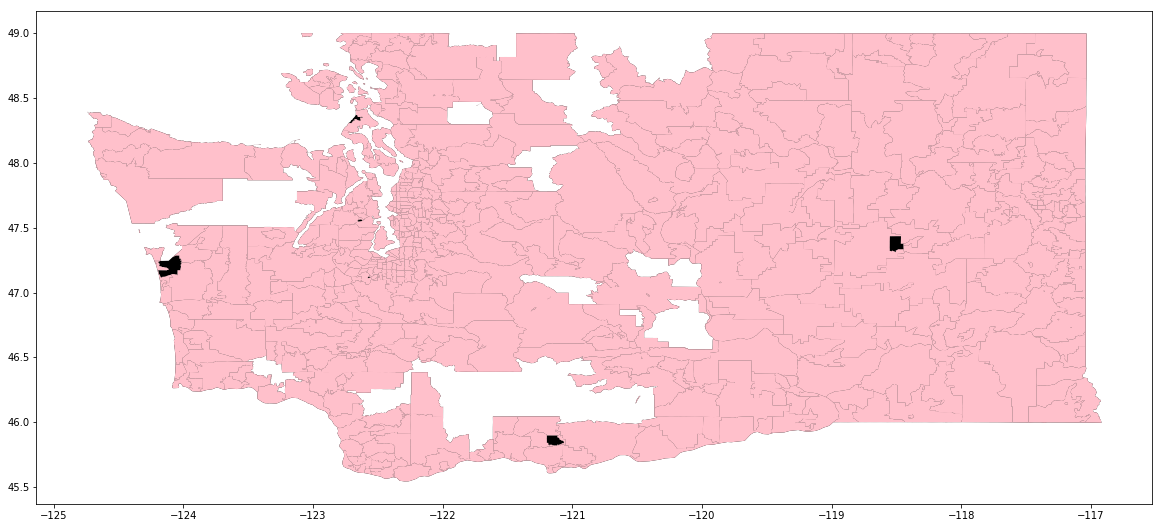

In [33]:
%matplotlib inline
base = wazipMap.plot(color='black',figsize=(20,13))

contribWAmap.plot(ax=base, color='pink')

All that we have done so far was not to produce that map, but to show in the map the information about contributions (_amount_). We have amounts, but we should not use that directly. We should compute a ratio, like:

$\frac{contributionOfZIP}{PopulationOfZIP}$

We do not have the zip area, but we do have a column on population:

In [34]:
#NOW that you are in maps, make sure column names are not longer than 10 characters
contribWAmap['contribDen']=contribWAmap.amount/contribWAmap.POP2017

The variable to plot is apparently ready, but let's explore it:

In [35]:
contribWAmap['contribDen'].describe()

count    587.000000
mean            inf
std             NaN
min        0.011824
25%        2.064583
50%        4.273223
75%        8.011527
max             inf
Name: contribDen, dtype: float64

We got an **inf**, because some zip codea had no population:

In [36]:
#finding the issue:
import numpy as np

contribWAmap[contribWAmap['contribDen']==np.inf][['contribDen']]

,contribDen
80,inf
82,inf
89,inf


We need to get rid of those rows:

In [37]:
contribWAmap=contribWAmap[contribWAmap['contribDen']!=np.inf]

That has solved the problem:

In [38]:
contribWAmap['contribDen'].describe()

count    584.000000
mean      10.804795
std       40.057601
min        0.011824
25%        2.058250
50%        4.230928
75%        7.891198
max      804.798650
Name: contribDen, dtype: float64

We will plot the new variable, the color palette can be chosen from [here](http://matplotlib.org/examples/color/colormaps_reference.html)

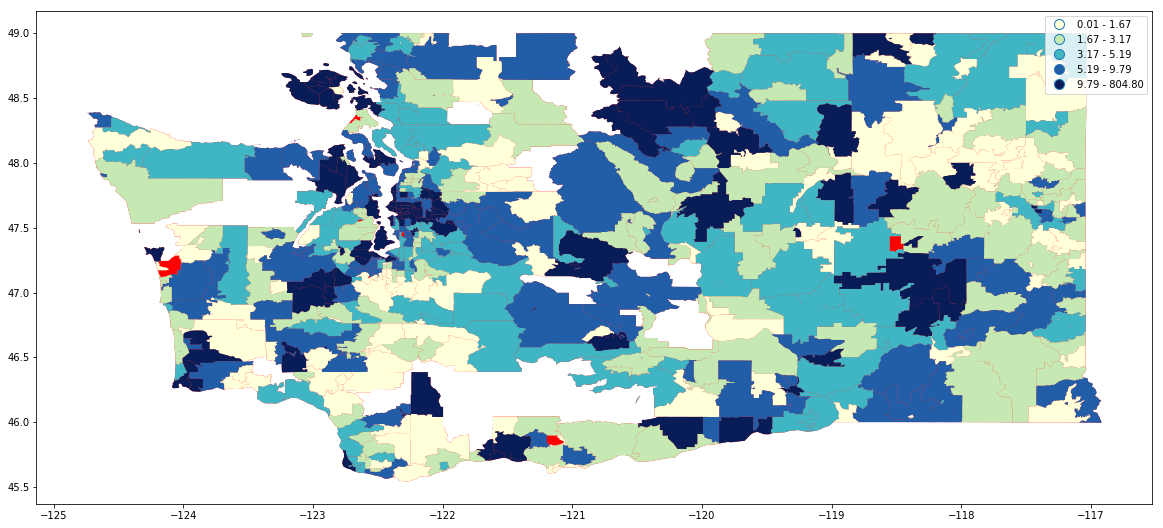

In [39]:
base = wazipMap.plot(color='red',figsize=(20,13))

contribWAmap.plot(ax=base,column='contribDen',cmap='YlGnBu',scheme='Quantiles',k=5,legend=True)

This is another approach where you tell where to put the legend (details [here](https://matplotlib.org/api/legend_api.html)):

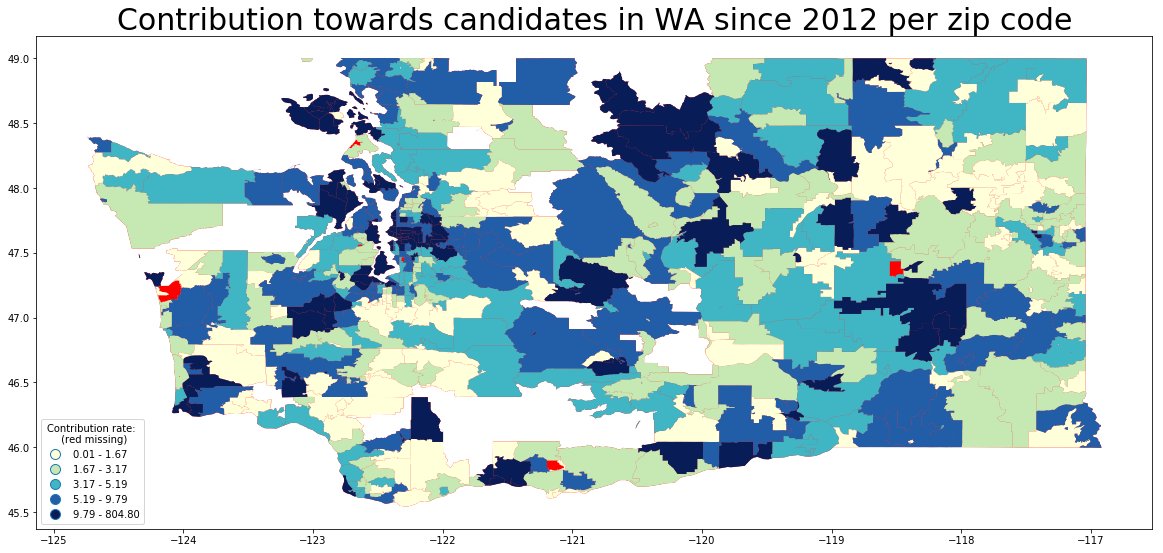

In [40]:
import matplotlib.pyplot as plt

base = wazipMap.plot(color='red',figsize=(20,13))

topLayer=contribWAmap.plot(ax=base,column='contribDen',cmap='YlGnBu',scheme='Quantiles',k=5,legend=True,
                  legend_kwds={'loc': 3,'title':'Contribution rate: \n (red missing)'})
topLayer.set_title('Contribution towards candidates in WA since 2012 per zip code', 
                   color='black',fontdict={'fontsize':30})
leg = topLayer.get_legend()
plt.setp(leg.get_title(), multialignment='center')
plt.show()

We can save the current map in your drive, you will see it generates more file with the same name but different extension:

In [ ]:
contribWAmap.to_file(driver = 'ESRI Shapefile', filename= "contribWAmap.shp")

### What if we had categories?

The situation is pretty similar. First get the data:

In [ ]:
# LINK

wikiLink = "https://en.wikipedia.org/wiki/Democracy_Index" # Location

# SCRAPING VIA PANDAS

import pandas as pd

wikiTables=pd.read_html(wikiLink,header=0,attrs={'class': 'wikitable sortable',})

# index 0 is the first element!
demodex=wikiTables[0]

Check the labels of _Category_:

In [ ]:
list(demodex.Category.value_counts().index)

Convert to the right type:

In [ ]:
# fast conversion:
from pandas.api.types import CategoricalDtype

goodOrderCat=['Authoritarian','Hybrid regime','Flawed democracy', 'Full democracy']
demodex.Category=demodex.Category.astype(CategoricalDtype(categories=goodOrderCat, 
                                         ordered=True))

Get rid of rows with missing values:

In [ ]:
demodex.dropna(inplace=True)

Get the map from Github:

In [ ]:
compressedMap2='https://github.com/EvansDataScience/data/raw/master/worldMap.zip'
worldMap = gpd.GeoDataFrame.from_file(compressedMap2)

Checking contents:

In [ ]:
worldMap.head()

Checking types:

In [ ]:
worldMap.dtypes

**Demodex** has no ISO nor FIPS code. Now, we could only use Name and Country to do the merge (we may lose several countries). 
Both columns are type _object_, so no need to change types:

In [ ]:
worldMapDem=worldMap.merge(demodex,left_on='NAME', right_on='Country')

Plotting both maps to see missing countries in the last one:

In [ ]:
# where is the missing countries:

base = worldMap.plot(color='black',figsize=(20,13),edgecolor='black')

worldMapDem.plot(ax=base, color='pink')

Now, plot your categorical variable:

In [ ]:
base = worldMap.plot(color='black',figsize=(20,13),edgecolor='black')

worldMapDem.plot(ax=base,column='Category',cmap='Set2',categorical=True,legend=True)

Unfortunately, the legend is shown using alphabetic order. We need a better strategy.

Every categorical has a number assigned to its levels, you need to use _cat.codes_ for that. Let me show you how it looks while concatenating the number to the level:

In [ ]:
list(zip(worldMapDem.Category.cat.codes,worldMapDem.Category))

I can create a **new** column using this:

In [ ]:
# I need str(x) because 'x' is a number, and numbers and text can not be concatenated with '+':
# zip is used to make parallel pairs:
[str(x)+'.'+y for (x,y) in zip(worldMapDem.Category.cat.codes+1,worldMapDem.Category)]

Here we create the new variable:

In [ ]:
worldMapDem['Category2']=[str(x)+'.'+y for (x,y) in zip(worldMapDem.Category.cat.codes+1,worldMapDem.Category)]

Now the plot:

In [ ]:
base = worldMap.plot(color='black',figsize=(20,13),edgecolor='black')
worldMapDem.plot(ax=base,column='Category2',cmap='Set2',categorical=True,legend=True)

More details:

In [ ]:
base = worldMap.plot(color='black',figsize=(20,13),edgecolor='black')
topLayer=worldMapDem.plot(ax=base,column='Category2',cmap='Set2',categorical=True,legend=True,
                  legend_kwds={'loc': 6,'title':'Democracy Level: \n (black missing)'})
topLayer.set_title('How democracy is spread around the world (2016)', 
                   color='black',fontdict={'fontsize':30})
leg = topLayer.get_legend()
plt.setp(leg.get_title(), multialignment='center')
plt.show()

_____

* [Go to Course schedule](https://evansdatascience.github.io/GovernanceAnalytics/)